In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, ticker
import os

import pyharm
from pyharm.util import i_of
import pyharm.plots.plot_dumps as pplt
from pyharm import flatten_xz, grid, flatten_xy
from pyharm.io import read_hdr
from pyharm import shell_sum
import pyharm.io.gridfile as gridfile
from mpl_toolkits.axes_grid1 import make_axes_locatable

dataloc = 'GRMHD_data/GRMHD_dt10M/Ma+0.94_w5/'
#dataloc = '/xdisk/chanc/proj/eht/GRMHD_dt5M/Ma+0.94_w5/'
ph = pyharm.load_dump(dataloc+'torus.out0.05780.h5')
#ph = pyharm.load_dump('GRMHD_data/GRMHD_v5/torus.out0.02000.phdf')

In [2]:
header = read_hdr(dataloc+'torus.out0.05780.h5')
ph = pyharm.load_dump(dataloc+'torus.out0.05780.h5')
r1d = ph['r1d']
# Generate a grid from the header of the file
G = grid.Grid(header, cache_conn=True)
native = ph.grid.coord_all()
#center = (native[:,0,0,0]-G.startx)[1:]
r = ph.grid.coords.r(native)
th = ph.grid.coords.th(native)
#cart_coord = ph.grid.coords.cart_coord(native)
### midplane radius
R = r * np.sin(th)

In [3]:
### calculate the magnetic flux within the bubble
def mask_disk(dump, bubble=True):
    if bubble:
        return np.where(np.logical_or(np.logical_and(dump['sigma']>1/2, R<5), np.logical_or(dump['Be_nob']>1.02, dump['rho']<=1e-2)), 0, 1)
    else:    
        return np.where(np.logical_or(R<5, np.logical_and(np.logical_and(dump['sigma']<1/2, dump['rho']>1e-2), dump['Be_nob']<1.02)), 1, 0)

def equatorial_flux(dump, var, mask=np.ones((288,128,128))):
    mask = mask[:, 64, :]
    if type(var) == str:
        var = dump[var][:, 64, :]
    elif type(var) == np.ndarray:
        var = var[:, 64, :]
    integrand = var * dump['gdet'][:, 64, :] * dump['dx3']
    return np.squeeze(np.sum(integrand * mask, axis=1))

In [4]:
mad_loc = dataloc
sane_loc = 'GRMHD_data/GRMHD_dt10M/Sa+0.94_w5/'

mad_names = np.sort(np.array([f for f in os.listdir(mad_loc) if os.path.isfile(os.path.join(mad_loc, f))]))
sane_names = np.sort(np.array([f for f in os.listdir(sane_loc) if os.path.isfile(os.path.join(sane_loc, f))]))

mad_j = np.zeros(288)
mad_m = np.zeros(288)
mad_jb = np.zeros(288)
mad_mb = np.zeros(288)
mad_eq_j = np.zeros(288)
mad_eq_m = np.zeros(288)
mad_eq_jb = np.zeros(288)
mad_eq_mb = np.zeros(288)

for mm in mad_names:
    dump = pyharm.load_dump(mad_loc+mm)
    mask = 1 - mask_disk(dump)
    FL = dump['FL']
    FM = dump['FM']

    mad_j = np.vstack((mad_j, shell_sum(dump, FL)))
    mad_m = np.vstack((mad_m, shell_sum(dump, FM)))
    mad_jb = np.vstack((mad_jb, shell_sum(dump, FL, mask=mask)))
    mad_mb = np.vstack((mad_mb, shell_sum(dump, FM, mask=mask)))
    mad_eq_j = np.vstack((mad_eq_j, equatorial_flux(dump, FL)))
    mad_eq_m = np.vstack((mad_eq_m, equatorial_flux(dump, FM)))
    mad_eq_jb = np.vstack((mad_eq_jb, equatorial_flux(dump, FL, mask=mask)))
    mad_eq_mb = np.vstack((mad_eq_mb, equatorial_flux(dump, FM, mask=mask)))

mad_j = mad_j[1:]
mad_m = mad_m[1:]
mad_jb = mad_jb[1:]
mad_mb = mad_mb[1:]
mad_eq_j = mad_eq_j[1:]
mad_eq_m = mad_eq_m[1:]
mad_eq_jb = mad_eq_jb[1:]
mad_eq_jm = mad_eq_mb[1:]

/home/ningyuanxu/.local/lib/python3.10/site-packages/pyharm/pyharm/variables.py:85: RuntimeWarning: divide by zero encountered in true_divide
  'sigma': lambda dump: dump['bsq'] / dump['RHO'],
/home/ningyuanxu/.local/lib/python3.10/site-packages/pyharm/pyharm/variables.py:85: RuntimeWarning: invalid value encountered in true_divide
  'sigma': lambda dump: dump['bsq'] / dump['RHO'],
/home/ningyuanxu/.local/lib/python3.10/site-packages/pyharm/pyharm/variables.py:267: RuntimeWarning: invalid value encountered in true_divide
  return -(1 + dump['gam'] * dump['UU'] / dump['RHO']) * dump['ucov'][0] - 1


In [5]:
np.save('ang_mtm_data/mad_j.npy', mad_j)
np.save('ang_mtm_data/mad_m.npy', mad_m)
np.save('ang_mtm_data/mad_jb.npy', mad_jb)
np.save('ang_mtm_data/mad_mb.npy', mad_mb)
np.save('ang_mtm_data/mad_eq_j.npy', mad_eq_j)
np.save('ang_mtm_data/mad_eq_m.npy', mad_eq_m)
np.save('ang_mtm_data/mad_eq_jb.npy', mad_eq_jb)
np.save('ang_mtm_data/mad_eq_mb.npy', mad_eq_mb)

In [6]:
dump2 = pyharm.load_dump(mad_loc+'torus.out0.05780.h5')

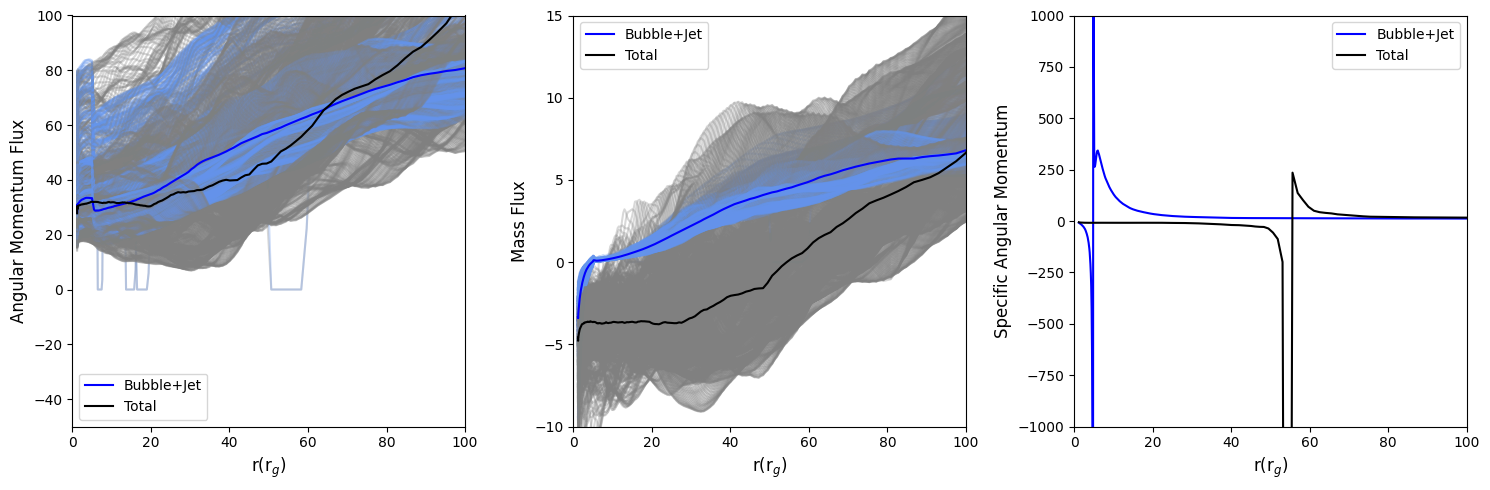

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
#mad_specific_j = np.reshape(np.ravel(mad_j)/np.ravel(mad_m), mad_j.shape)

for ii in range(mad_j.shape[0]):
    axs[0].plot(r1d, mad_j[ii], color='grey', ls='-', alpha=0.3)
    axs[1].plot(r1d, mad_m[ii], color='grey', ls='-', alpha=0.3)
    #axs[2].plot(r1d, mad_specific_j[ii], color='gray', ls='-', alpha=0.3)
    
    axs[0].plot(r1d, mad_jb[ii], color='cornflowerblue', ls='-', alpha=0.3)
    axs[1].plot(r1d, mad_mb[ii], color='cornflowerblue', ls='-', alpha=0.3)
    #axs[2].plot(r1d, mad_specific_j[ii], color='gray', ls='-', alpha=0.3)
    
axs[0].plot(r1d, np.median(mad_jb, axis=0), 'b-', label='Bubble+Jet')
axs[1].plot(r1d, np.median(mad_mb, axis=0), 'b-', label='Bubble+Jet')
#axs[2].plot(r1d, np.median(mad_specific_j, axis=0), 'r.')
axs[2].plot(r1d, np.median(mad_jb, axis=0)/np.median(mad_mb, axis=0), 'b-', label='Bubble+Jet')
    
axs[0].plot(r1d, np.median(mad_j, axis=0), 'k-', label='Total')
axs[1].plot(r1d, np.median(mad_m, axis=0), 'k-', label='Total')
#axs[2].plot(r1d, np.median(mad_specific_j, axis=0), 'r.')
axs[2].plot(r1d, np.median(mad_j, axis=0)/np.median(mad_m, axis=0), 'k-', label='Total')

axs[0].set_ylim([-50, 100])
axs[1].set_ylim([-10, 15])
axs[2].set_ylim([-1000, 1000])

axs[0].set_ylabel('Angular Momentum Flux', fontsize=12)
axs[1].set_ylabel('Mass Flux', fontsize=12)
axs[2].set_ylabel('Specific Angular Momentum', fontsize=12)

for ax in axs:
    ax.set_xlabel(r'r(r$_g$)', fontsize=12)
    ax.set_xlim([0, 100])
    ax.legend()

plt.tight_layout()
plt.show()

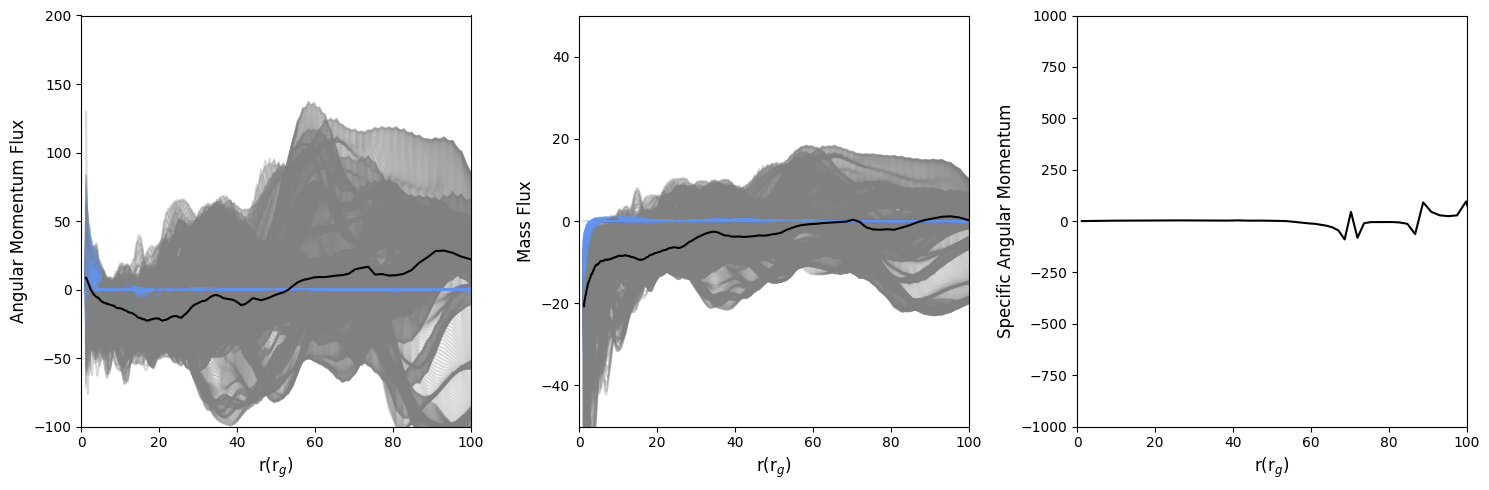

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
#mad_specific_j = np.reshape(np.ravel(mad_j)/np.ravel(mad_m), mad_j.shape)

for ii in range(mad_eq_j.shape[0]):
    axs[0].plot(r1d, mad_eq_j[ii], color='grey', ls='-', alpha=0.3)
    axs[1].plot(r1d, mad_eq_m[ii], color='grey', ls='-', alpha=0.3)
    #axs[2].plot(r1d, mad_specific_j[ii], color='gray', ls='-', alpha=0.3)

    axs[0].plot(r1d, mad_eq_jb[ii], color='cornflowerblue', ls='-', alpha=0.3)
    axs[1].plot(r1d, mad_eq_mb[ii], color='cornflowerblue', ls='-', alpha=0.3)
    
axs[0].plot(r1d, np.median(mad_eq_j, axis=0), 'k-')
axs[1].plot(r1d, np.median(mad_eq_m, axis=0), 'k-')
#axs[2].plot(r1d, np.median(mad_specific_j, axis=0), 'r.')
axs[2].plot(r1d, np.median(mad_eq_j, axis=0)/np.median(mad_eq_m, axis=0), 'k-')

axs[0].set_ylim([-100, 200])
axs[1].set_ylim([-50, 50])
axs[2].set_ylim([-1000, 1000])

axs[0].set_ylabel('Angular Momentum Flux', fontsize=12)
axs[1].set_ylabel('Mass Flux', fontsize=12)
axs[2].set_ylabel('Specific Angular Momentum', fontsize=12)

for ax in axs:
    ax.set_xlabel(r'r(r$_g$)', fontsize=12)
    ax.set_xlim([0, 100])

plt.tight_layout()
plt.show()

In [94]:
mad_loc = dataloc
sane_loc = 'GRMHD_data/GRMHD_dt10M/Sa+0.94_w5/'

mad_names = np.sort(np.array([f for f in os.listdir(mad_loc) if os.path.isfile(os.path.join(mad_loc, f))]))
sane_names = np.sort(np.array([f for f in os.listdir(sane_loc) if os.path.isfile(os.path.join(sane_loc, f))]))

#mad_phi = []
#mad_acc = []
#sane_phi = []
#sane_acc = []

for mm in mad_names[:1]:
    dump = pyharm.load_dump(mad_loc+mm)
    FL = dump['FL']
    FM = dump['FM']
    
    #mad_phi.append(0.5 * pyharm.shell_sum(dump, 'abs_B1', at_i=5) / np.sqrt(np.abs(pyharm.shell_sum(dump, 'FM', at_i=5))))
    #mad_acc.append(-pyharm.shell_sum(dump, 'FM', at_i=5))

#for ss in sane_names:
#    dump = pyharm.load_dump(sane_loc+ss)
#    sane_phi.append(0.5 * pyharm.shell_sum(dump, 'abs_B1', at_i=5) / np.sqrt(np.abs(pyharm.shell_sum(dump, 'FM', at_i=5))))
#    sane_acc.append(-pyharm.shell_sum(dump, 'FM', at_i=5))

#mad_phi = np.array(mad_phi)
#mad_acc = np.array(mad_acc)
#sane_phi = np.array(sane_phi)
#sane_acc = np.array(sane_acc)

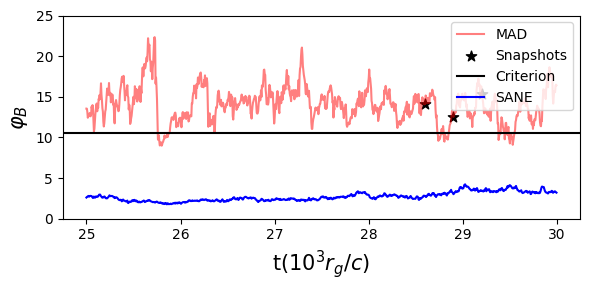

In [3]:
t = np.arange(5, 6, 0.001)*5
fig, axs = plt.subplots(1, 1, figsize=(6, 3))
axs.plot(t, mad_phi, 'r-', label='MAD', alpha=0.5)
axs.set_ylabel(r'$\varphi_B$', fontsize=15)
axs.scatter(t[720], mad_phi[720], 60, color='black', marker='*')
axs.scatter(t[780], mad_phi[780], 60, color='black', marker='*')
axs.scatter(t[840], mad_phi[840], 60, color='black', marker='*', label='Snapshots')
#axs.scatter(t[170], sane_phi[170], 60, color='black', marker='*', label='Snapshot')
axs.axhline(10.6, color='k', label='Criterion')
axs.set_ylim([0, 25])
#axs[1].plot(t, mad_acc, 'r-', label='MAD')
#axs.set_ylabel(r'$\dot M$', fontsize=15)
axs.plot(t, sane_phi, 'b-', label='SANE')
#axs[1].plot(t, sane_acc, 'b-', label='SANE')
#axs[1].set_ylim([0, 15])
axs.set_xlabel(r't($10^3 r_g/c$)', fontsize=15)
#axs[0].set_xlim([25.7, 25.8])
axs.legend()
plt.tight_layout()
plt.savefig('MAD_flux.png', dpi=300)
plt.show()

In [5]:
np.save('ang_mtm_data/mad_phi.npy', mad_phi)
np.save('ang_mtm_data/sane_phi.npy', sane_phi)

In [2]:
def get_contour(ph, level=-3, levels=3):
    xc, yc = ph.grid.get_xy_locations(mesh=False, native=False, log_r=False)
    var = flatten_xy(ph, 'log_rho')
    cs = plt.contour(xc, yc, var, levels=levels, alpha=0)
    item = cs.collections[level]
    contour_x = []
    contour_y = []
    for i in item.get_paths():
        v = i.vertices
        if np.any(np.abs(v) > 75):
            contour_x = contour_x
            contour_y = contour_y
        else:
            contour_x.append(v[:, 0])
            contour_y.append(v[:, 1])
    return contour_x, contour_y

In [14]:
ph_before = pyharm.load_dump(dataloc+'torus.out0.05170.h5')
ph_during = pyharm.load_dump(dataloc+'torus.out0.05185.h5')
ph_after = pyharm.load_dump(dataloc+'torus.out0.05200.h5')
ph = pyharm.load_dump(dataloc+'torus.out0.05980.h5')
ph_gen = pyharm.load_dump(dataloc+'torus.out0.05780.h5')
#ph_sane = pyharm.load_dump(sane_loc+'torus.out0.05170.h5')

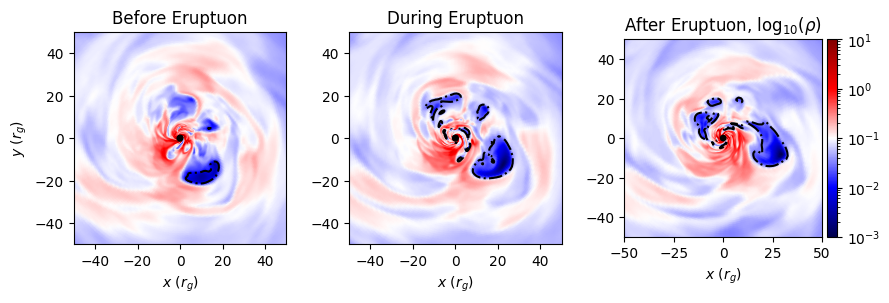

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
window=[-50, 50, -50, 50]

pplt.plot_xy(axs[0], ph_before, 'log_rho', window=window, cmap='seismic', 
                 vmin=1e-3, vmax=1e1, cbar=False, xticks=None, label='Before Eruptuon')
contour_x, contour_y = get_contour(ph_before)
for i in range(len(contour_x)):
    axs[0].plot(contour_x[i], contour_y[i], 'k', ls='-.')
    
pplt.plot_xy(axs[1], ph_during, 'log_rho', window=window, cmap='seismic', 
                 vmin=1e-3, vmax=1e1, ylabel=False, cbar=False, 
             xtick=None, yticks=None,label='During Eruptuon')
contour_x, contour_y = get_contour(ph_during, level=-3, levels=4)
for i in range(len(contour_x)):
    axs[1].plot(contour_x[i], contour_y[i], 'k', ls='-.')

pplt.plot_xy(axs[2], ph_after, 'log_rho', window=window, cmap='seismic', 
                 vmin=1e-3, vmax=1e1, ylabel=False, label=r'After Eruptuon, log$_{10}(\rho)$')
contour_x, contour_y = get_contour(ph_after)
for i in range(len(contour_x)):
    axs[2].plot(contour_x[i], contour_y[i], 'k', ls='-.')

plt.tight_layout()
#plt.savefig('density_comp.png', dpi=300)
plt.show()

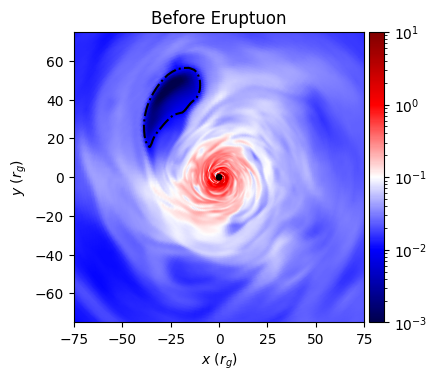

In [5]:
fig, axs = plt.subplots(1, 1, figsize=(4,4))
window=[-75, 75, -75, 75]

pplt.plot_xy(axs, ph, 'log_rho', window=window, cmap='seismic', 
                 vmin=1e-3, vmax=1e1, cbar=True, xticks=None, label='Before Eruptuon')
contour_x, contour_y = get_contour(ph)
for i in range(len(contour_x)):
    axs.plot(contour_x[i], contour_y[i], 'k', ls='-.')
plt.show()

In [5]:
header = read_hdr(dataloc+'torus.out0.05780.h5')
# Generate a grid from the header of the file
G = grid.Grid(header, cache_conn=True)
native = ph.grid.coord_all()
#center = (native[:,0,0,0]-G.startx)[1:]
r = ph.grid.coords.r(native)
th = ph.grid.coords.th(native)
#cart_coord = ph.grid.coords.cart_coord(native)
### midplane radius
R = r * np.sin(th)

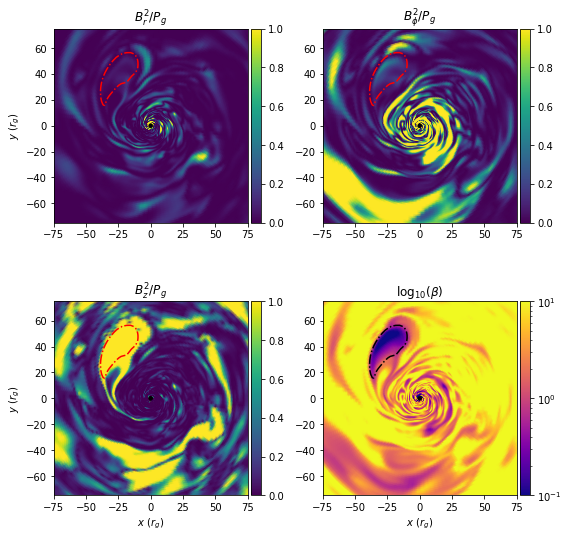

In [25]:
#br = (ph['b^r'] * ph['u^t'] - ph['b^t'] * ph['u^r']) * np.sin(th)
#bphi = ph['b^phi'] * ph['u^t'] - ph['b^t'] * ph['u^phi']
#bz = ph['b^z'] * ph['u^t'] - ph['b^t'] * ph['u^z']

bz_ratio = np.abs(ph['b^z']*ph['b_z'])/ ph['Pg']
br_ratio = np.abs(ph['b^r']*ph['b_r'])/ ph['Pg']
bphi_ratio = np.abs(ph['b^phi']*ph['b_phi'])/ ph['Pg']

H = pyharm.shell_avg(ph, np.abs(np.pi/2-th)*ph['rho'])/pyharm.shell_avg(ph, 'rho')
H_mat = H[:, np.newaxis, np.newaxis] * np.ones((128, 128))
H_ave = r * H_mat
lam_mri = ph['lam_MRI_transform']
s_mri = np.abs(2*H_ave/lam_mri)

fig, axs = plt.subplots(2,2,figsize=(8,8))
#pplt.plot_xy(axs[0,0], ph, 'log_rho', cmap='seismic', window=(-75, 75, -75, 75), 
#            vmin=1e-3, vmax=1e1, xlabel=False)
pplt.plot_xy(axs[0,0], ph, br_ratio, cmap='viridis', window=(-75, 75, -75, 75), 
            vmin=0, vmax=1, xlabel=False, label=r'$B_{r}^2/P_g$')
contour_x, contour_y = get_contour(ph)
for i in range(len(contour_x)):
    axs[0,0].plot(contour_x[i], contour_y[i], 'r', ls='-.')

pplt.plot_xy(axs[0,1], ph, bphi_ratio, cmap='viridis', window=(-75, 75, -75, 75), 
            vmin=0, vmax=1, xlabel=False, ylabel=False, label=r'$B_{\phi}^2/P_g$')
for i in range(len(contour_x)):
    axs[0,1].plot(contour_x[i], contour_y[i], 'r', ls='-.')

pplt.plot_xy(axs[1,0], ph, bz_ratio, cmap='viridis', window=(-75, 75, -75, 75), 
            vmin=0, vmax=1, label=r'$B_z^2/P_g$')
for i in range(len(contour_x)):
    axs[1,0].plot(contour_x[i], contour_y[i], 'r', ls='-.')

#pplt.plot_xy(axs[1,1], ph, np.log10(s_mri), cmap='viridis', window=(-75, 75, -75, 75), 
#            vmin=-2, vmax=1, label=r'log$_{10}(S_{MRI})$', ylabel=False)
pplt.plot_xy(axs[1,1], ph, 'log_beta', cmap='plasma', window=(-75, 75, -75, 75), 
            vmin=1e-1, vmax=10, ylabel=False)
for i in range(len(contour_x)):
    axs[1,1].plot(contour_x[i], contour_y[i], 'k', ls='-.')
    
plt.tight_layout()
plt.savefig('figures/b_comp.png', dpi=300)
plt.show()

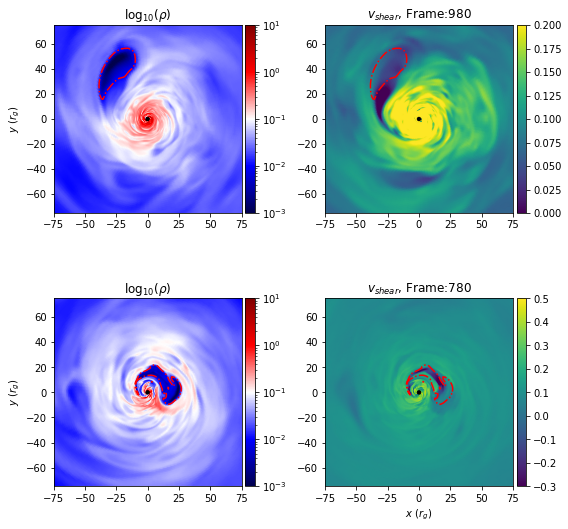

In [19]:
fig, axs = plt.subplots(2,2,figsize=(8,8))
pplt.plot_xy(axs[0,0], ph, 'log_rho', cmap='seismic', window=(-75, 75, -75, 75), 
            vmin=1e-3, vmax=1e1, xlabel=False)
contour_x, contour_y = get_contour(ph)
for i in range(len(contour_x)):
    axs[0,0].plot(contour_x[i], contour_y[i], 'r', ls='-.')
    
vsh = ph['Omega']*R
pplt.plot_xy(axs[0,1], ph, vsh, cmap='viridis', window=(-75, 75, -75, 75), 
             vmin=0, vmax=0.2, ylabel=False, xlabel=False, label=r'$v_{shear}$, Frame:980')
contour_x, contour_y = get_contour(ph)
for i in range(len(contour_x)):
    axs[0,1].plot(contour_x[i], contour_y[i], 'r', ls='-.')
    
pplt.plot_xy(axs[1,0], ph_gen, 'log_rho', cmap='seismic', window=(-75, 75, -75, 75), 
            vmin=1e-3, vmax=1e1, xlabel=False)
contour_x, contour_y = get_contour(ph_gen)
for i in range(len(contour_x)):
    axs[1,0].plot(contour_x[i], contour_y[i], 'r', ls='-.')    

vsh = ph_gen['Omega']*R
pplt.plot_xy(axs[1,1], ph, vsh, cmap='viridis', window=(-75, 75, -75, 75), 
             vmin=-0.3, vmax=0.5, ylabel=False, label=r'$v_{shear}$, Frame:780')
contour_x, contour_y = get_contour(ph_gen)
for i in range(len(contour_x)):
    axs[1,1].plot(contour_x[i], contour_y[i], 'r', ls='-.')
    
plt.tight_layout()
plt.show()

In [59]:
contour_x, contour_y = get_contour(ph)
plt.close()
bubble_rmin = np.sqrt(np.min(np.asarray(contour_x)**2+np.asarray(contour_y)**2))
bubble_rmax = np.sqrt(np.max(np.asarray(contour_x)**2+np.asarray(contour_y)**2))
print(bubble_rmin, bubble_rmax)

38.414778736244955 60.12178442210899


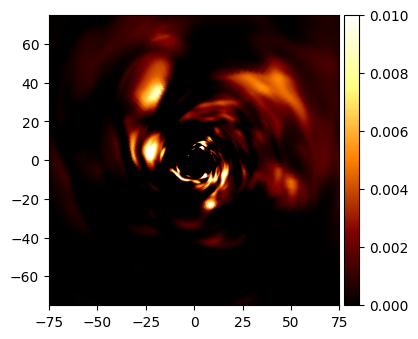

In [11]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
vsh = (ph['Omega']*R)**2
#vsh = ph['u^phi']*ph['u_phi']
vr = ph['u^r']*ph['u_r']
pplt.plot_xy(ax, ph, vr, cmap='afmhot', ylabel=False, xlabel=False, window=[-75, 75, -75, 75], vmin=0, vmax=0.01)
#contour_x, contour_y = get_contour(ph)
#for i in range(len(contour_x)):
#    ax.plot(contour_x[i], contour_y[i], 'r', ls='-.')
plt.savefig('test.png', dpi=100)
plt.show()